# Text Mining Project 2022/23, NOVA IMS, MDSAA

# Group 15

## Authors: 
**Adriana Monteiro 20220604\
Mafalda Paço 20220619\
Marta Dinis 20220611\
Patricia Morais 20220638**


## Index<a class="anchor" id="index" />

1 - [Imports](#topic01) <br>
2 - [Functions to handle data](#topic02) <br>
>   2.1 [Preprocess functions](#topic02.01) <br>
    2.2 [Other functions](#topic02.02) <br>

3 - [Import and Preprocess data](#topic03) <br>
 >  3.1 [Importing Data](#topic03.01) <br>
    3.2 [Exploratory Analysis](#topic03.02) <br>
    3.3 [Data Preprocessing](#topic03.03) <br>


4 - [Data Visualization](#topic04) <br>

5 - [Import and Exploration of Sentiment Analysis](#topic05) <br>


<a class="anchor" id="topic01" /><br>
# Step 1: Import of all needed libraries
[Back to Index](#index)

In [ ]:
#!pip install vaderSentiment
#!pip install wordcloud
#!pip install pysentimiento
#!pip install vaderSentiment-fr
#!pip install imbalanced-learn
#!pip install gensim
#!python -m spacy download pt_core_news_sm
#!python -m spacy download fr_core_news_sm
#!python -m spacy download en_core_web_sm
#!pip install contractions
#!pip install emoji

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as siden
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer as sidfr
from pysentimiento import create_analyzer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import emoji
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random
import math
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

import tqdm
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from collections import Counter
import seaborn as sns
import plotly.express as px
import re
import plotly.graph_objects as go
from plotly.subplots import make_subplots

<a class="anchor" id="topic02" /><br>
# Step 2: Define functions to handle data
[Back to Index](#index)

<a class="anchor" id="topic02.01" /><br>
### 2.1 Preprocess functions

### Remove Html

In [4]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(dataframe):
    dataframe_cleaned = dataframe.copy()
    for column in dataframe_cleaned.columns:
        if column in text_columns_reviews+text_columns_airbnb:
            dataframe_cleaned[column] = dataframe_cleaned[column].apply(lambda x: re.sub(CLEANR, ' ', x))
            dataframe_cleaned[column] = dataframe_cleaned[column].str.replace('\n', '')
    
    dataframe_cleaned.reset_index(drop=True, inplace = True)
    return dataframe_cleaned

### Lowercasing

In [5]:
def lowercasing(dataframe):
    dataframe_lowercased = dataframe.copy()
    for column in dataframe_lowercased.columns:
        if column in text_columns_reviews+text_columns_airbnb:
            dataframe_lowercased[column] = dataframe_lowercased[column].str.lower()
    
    dataframe_lowercased.reset_index(drop=True, inplace = True)

    return dataframe_lowercased

### Remove punctuation

In [6]:
def remove_punctuation(dataframe):
    dataframe_unpunctuation = dataframe.copy()
    for column in dataframe_unpunctuation.columns:
        if column in text_columns_reviews + text_columns_airbnb:
            dataframe_unpunctuation[column] = dataframe_unpunctuation[column].str.replace(f"[{re.escape(string.punctuation)}]", ' ')
            dataframe_unpunctuation[column] = dataframe_unpunctuation[column].str.replace(' +', ' ')
            dataframe_unpunctuation[column] = dataframe_unpunctuation[column].apply(lambda x: str(x).encode("ascii", "ignore").decode())
    dataframe_unpunctuation.reset_index(drop=True, inplace = True)
    return dataframe_unpunctuation

### Remove empty

In [7]:
def remove_empty(dataframe):
    dataframe_noempty = dataframe.copy()
    for column in dataframe_noempty.columns:
        dataframe_noempty[column].replace('', np.nan, inplace=True)
        dataframe_noempty.replace(r'^\s+$', np.nan, regex=True, inplace = True) 
        dataframe_noempty.dropna(subset=[column], inplace=True)
    dataframe_noempty.reset_index(drop=True, inplace = True)
    return dataframe_noempty

### Remove emojis

In [8]:
def remove_emoji(dataframe, columns):
    dataframe_unemoji = dataframe.copy()
    for column in columns:
        dataframe_unemoji[column] = dataframe_unemoji[column].apply(lambda s: emoji.replace_emoji(s, ''))
    dataframe_unemoji.reset_index(drop=True, inplace = True)
    return dataframe_unemoji

### Replace emojis

In [9]:
def convert_emoji(dataframe, columns):
    dataframe_reemoji = dataframe.copy()

    for column in columns:
        index= 0
        for row in dataframe_reemoji[column]:
            if dataframe_reemoji[column+"_lang"][index] == "en":
                dataframe_reemoji[column][index] = emoji.demojize(dataframe_reemoji[column][index])
            elif dataframe_reemoji[column+"_lang"][index] == "pt":
                dataframe_reemoji[column][index] = emoji.demojize(dataframe_reemoji[column][index], language='pt')
            elif dataframe_reemoji[column+"_lang"][index] == "fr":
                dataframe_reemoji[column][index] = emoji.demojize(dataframe_reemoji[column][index], language='fr')
            else:
                dataframe_reemoji[column][index] = emoji.replace_emoji(dataframe_reemoji[column][index], '')
            index+=1
    dataframe_reemoji.reset_index(drop=True, inplace = True)
    return dataframe_reemoji

### Expand contractions

In [10]:
def expand_contractions(dataframe):
    dataframe_contractions = dataframe.copy()
    
    def remove_cont(text):
        expanded_words = []   
        for word in text.split():
            expanded_words.append(contractions.fix(word)) 
        return ' '.join(expanded_words)
        
    for column in dataframe_contractions.columns:
        if column in text_columns_reviews + text_columns_airbnb:
            dataframe_contractions[column] = dataframe_contractions[column].apply(remove_cont)
            dataframe_contractions[column] = dataframe_contractions[column].str.replace('’s', '')
    dataframe_contractions.reset_index(drop=True, inplace = True)
    return dataframe_contractions

### Remove patterns of digits

In [11]:
def remove_digits(dataframe, columns):
    dataframe_digits = dataframe.copy()
    for column in columns:
        dataframe_digits[column] = dataframe_digits[column].apply(lambda x: x.replace("x000d ", ""))
        dataframe_digits[column] = dataframe_digits[column].apply(lambda x: re.sub(r'\d+', '', x))
    dataframe_digits.reset_index(drop=True, inplace = True)
    return dataframe_digits

### Removing stopwords

In [12]:
def remove_stopwords(dataframe, columns):
    dataframe_stop= dataframe.copy()
    stopwords_pt = nltk.corpus.stopwords.words('portuguese')
    stopwords_en = nltk.corpus.stopwords.words('english')
    stopwords_fr = nltk.corpus.stopwords.words('french')
    for column in columns:
        counter= 0
        for row in dataframe_stop[column]:
            if dataframe_stop[column+"_lang"][counter] == "en":
                dataframe_stop[column][counter] = " ".join([word for word in str(row).split() if word not in stopwords_en])  
            elif dataframe_stop[column+"_lang"][counter] == "pt":
                dataframe_stop[column][counter] = " ".join([word for word in str(row).split() if word not in stopwords_pt])
            elif dataframe_stop[column+"_lang"][counter] == "fr":
                dataframe_stop[column][counter] = " ".join([word for word in str(row).split() if word not in stopwords_fr])
            else:
                dataframe_stop[column][counter] = dataframe_stop[column][counter]
            counter+=1
    
    dataframe_stop.reset_index(drop=True, inplace = True)

    return dataframe_stop

### Tokenization

In [13]:
def tokenize(dataframe, columns):
    dataframe_token= dataframe.copy()
    for column in columns:
        counter= 0
        for row in dataframe_token[column]:
            if dataframe_token[column+"_lang"][counter] == "en":
                dataframe_token[column][counter] = word_tokenize(row, language='english')     
            elif dataframe_token[column+"_lang"][counter] == "pt":
                dataframe_token[column][counter] = word_tokenize(row, language='portuguese') 
            elif dataframe_token[column+"_lang"][counter] == "fr":
                dataframe_token[column][counter] = word_tokenize(row, language='french') 
            else:
                dataframe_token[column][counter] = row.split()
            counter+=1
    
    return dataframe_token

### Lemmatization

In [14]:
def lemmatize(dataframe, columns):
    dataframe_lemmas = dataframe.copy()
    
    nlp_en = spacy.load("en_core_web_sm")
    nlp_pt = spacy.load("pt_core_news_sm")
    nlp_fr = spacy.load("fr_core_news_sm")
    nlp_fr = spacy.load("fr_core_news_sm")
    
    for column in columns:
        counter = 0
        
        for row in dataframe_lemmas[column]:
            if dataframe_lemmas[column+"_lang"][counter] == "en":
                doc = nlp_en(row)
                dataframe_lemmas[column][counter] = ' '.join([token.lemma_ for token in doc])  
            elif dataframe_lemmas[column+"_lang"][counter] == "pt":
                doc = nlp_pt(row)
                dataframe_lemmas[column][counter] =  ' '.join([token.lemma_ for token in doc])
            elif dataframe_lemmas[column+"_lang"][counter] == "fr":
                doc = nlp_fr(row)
                dataframe_lemmas[column][counter] =  ' '.join([token.lemma_ for token in doc])
            else:
                dataframe_lemmas[column][counter] = dataframe_lemmas[column][counter]
            counter += 1
    dataframe_lemmas.reset_index(drop=True, inplace = True)

    return dataframe_lemmas

### Detect Language

In [15]:
#!python -m spacy download en_core_web_sm
def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42

nlp_model = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)

In [16]:
def detect_language(dataframe, columns):
    dataframe_lang = dataframe.copy()
    
    def dl(text):
        doc = nlp_model(text)
        lang = None
        for sent in doc.sents:
            lang = sent._.language['language']
        return lang  # Return the language for the first sentence
    
    for column in columns:
        dataframe_lang[column+'_lang'] = dataframe_lang[column].apply(dl)
    
    dataframe_lang.reset_index(drop=True, inplace = True)
    
    return dataframe_lang

### Calculate language percentage in the dataset

In [17]:
def lang_percentage(n,df_language, col):
    data = df_language[col].value_counts().rename_axis('languages').reset_index(name='counts')
    percentage=[]
    languages=[]
    absol = []
    for i in range(n):
        percentage.append(data['counts'][i]/len(df_language))
        languages.append(data['languages'][i])
        absol.append(data['counts'][i])
    perc_language = pd.DataFrame({"languages": languages, "percentage":percentage, 'count':absol})

    return perc_language

<a class="anchor" id="topic02.02" /><br>
### 2.2 Other functions

### Setiment Analysis

In [18]:
def sentiment_reviews(df, columns):
    
    dataframe_sentiment = df.copy()
    analyser_pt = create_analyzer(task="sentiment", lang="pt")
    sid_en = siden()
    sid_fr = sidfr()
    sentiment = []

    for column in columns:
        counter = 0
        total_rows = len(dataframe_sentiment[column])

        for row in tqdm.tqdm(dataframe_sentiment[column], total=total_rows, desc=f"Sentiment Analysis of {column}"):

            if dataframe_sentiment[column+"_lang"][counter] == "en":
                score = sid_en.polarity_scores(dataframe_sentiment[column][counter])['compound']
                if score >= 0.05:
                    sentiment.append(1)
                elif score <= -0.05:
                    sentiment.append(-1)
                elif -0.05 < score < 0.05:
                    sentiment.append(0)
                
   
            elif dataframe_sentiment[column+"_lang"][counter] == "pt":
                score = analyser_pt.predict(dataframe_sentiment[column][counter]).output
                if score == 'POS':
                    sentiment.append(1)
                elif score == 'NEG':
                    sentiment.append(-1)
                elif score == 'NEU':
                    sentiment.append(0)
            

            elif dataframe_sentiment[column+"_lang"][counter] == "fr":
                score = sid_fr.polarity_scores(dataframe_sentiment[column][counter])['compound']
                if score >= 0.05:
                    sentiment.append(1)
                elif score <= -0.05:
                    sentiment.append(-1)
                elif -0.05 < score < 0.05:
                    sentiment.append(0)
            
            else:
                sentiment.append(0)
            
            counter += 1

    dataframe_sentiment['sentiment'] = sentiment
    
    return dataframe_sentiment

<a class="anchor" id="topic03" /><br>
# Step 3: Import and Exploration of data
[Back to Index](#index)

<a class="anchor" id="topic03.01" /><br>
### 3.1 Importing data
[Back to Index](#index)

In [19]:
# Import data
airbnb_df_train = pd.read_excel('../data/train.xlsx')
reviews_df_train = pd.read_excel('../data/train_reviews.xlsx')

airbnb_df_test = pd.read_excel('../data/test.xlsx')
reviews_df_test = pd.read_excel('../data/test_reviews.xlsx')

# Set index
airbnb_df_train.set_index('index', drop=True, inplace=True)
airbnb_df_test.set_index('index', drop=True, inplace=True)

# Set text columns
text_columns_airbnb = ["description","host_about"]
text_columns_reviews = ["comments"]

# Set text columns as strings
airbnb_df_train = airbnb_df_train.astype({'description':'string', 'host_about':'string'})
reviews_df_train = reviews_df_train.astype({'comments':'string'})


In [71]:
airbnb_df_train.head()

description  \
index                                                      
1      This is a shared mixed room in our hostel, wit...   
2      O meu espaço fica perto de Parque Eduardo VII,...   
3      Trafaria’s House is a cozy and familiar villa ...   
4      Apartamento Charmoso no Chiado, Entre o Largo ...   
5      Joli appartement  en bordure de mer.<br /> 2 m...   

                                              host_about  unlisted  
index                                                               
1                    Alojamento Local Registro: 20835/AL         0  
2      I am friendly host, and I will try to always b...         1  
3      I am a social person liking to communicate, re...         1  
4      Hello!_x000D_
I m Portuguese and i love to mee...         0  
5      Nous sommes une famille avec deux enfants de 1...         0

In [72]:
reviews_df_train.head()

index                                           comments
0      1  this is a very cozy and comfortable house to s...
1      1                                          good<br/>
2      1  My first hostel experience, and all I have to ...
3      1  Das Hostel war neu und deshalb funktionierte a...
4      1  It was fine for a dorm, but I think for the pe...

<a class="anchor" id="topic03.02" /><br>
### 3.2 Exploratory Analysis

### Checking null values --> there aren't any

In [73]:
airbnb_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12496 entries, 1 to 12496
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  12496 non-null  string
 1   host_about   12496 non-null  string
 2   unlisted     12496 non-null  int64 
dtypes: int64(1), string(2)
memory usage: 390.5 KB


In [74]:
reviews_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721402 entries, 0 to 721401
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     721402 non-null  int64 
 1   comments  721402 non-null  string
dtypes: int64(1), string(1)
memory usage: 11.0 MB


### Listed and unlisted analysis

In [75]:
print("We have {}% of unlisted properties in our dataset".format(round((airbnb_df_train[airbnb_df_train['unlisted'] == 1]['unlisted'].count()/len(airbnb_df_train))*100)))

We have 28% of unlisted properties in our dataset


Text(0.5, 1.0, 'Unlisted')

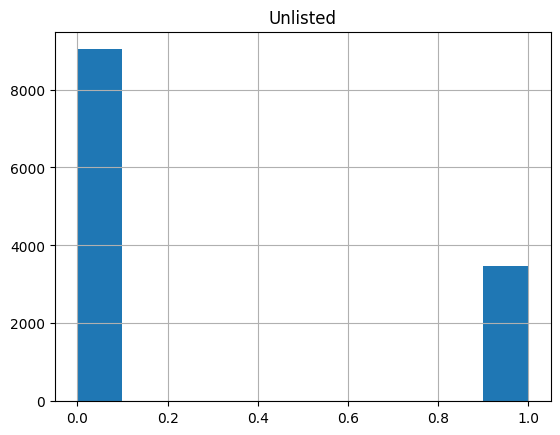

In [76]:
airbnb_df_train['unlisted'].hist()
plt.title("Unlisted")

### Number of airbnbs reviewed

In [77]:
print("Only {}% of properties in our dataset are reviewed".format(round((reviews_df_train['index'].nunique()/len(reviews_df_train))*100)))

Only 1% of properties in our dataset are reviewed


### Number of reviews for each airbnb 

Text(0.5, 1.0, 'Amount of reviews per listing')

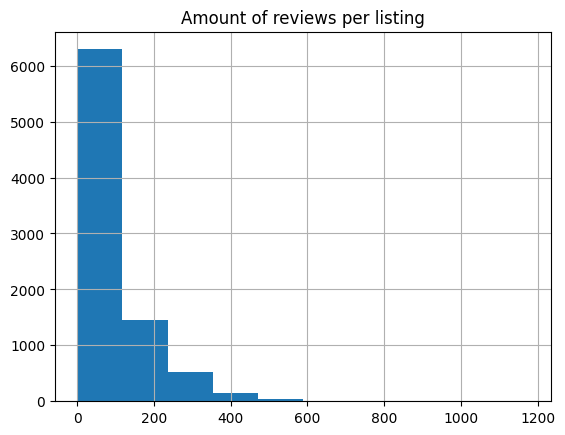

In [78]:
reviews_df_train.groupby('index').count().sort_values('comments',ascending=False).hist()
plt.title("Amount of reviews per listing")

## Text (Independent features)

In [79]:
airbnb_df_train['description'][10]

'Walk up original wooden stairs to the entrance of an apartment bathed in light. Here, wooden fixtures rest atop hardwood floors and are accentuated by bold blues and vibrant plant life. Play a game on the tennis court and dive into the pool.<br /><br /><b>License number</b><br />80419/AL'

In [80]:
airbnb_df_train['host_about'][27]

'Somos Lucia e Luis_x000D_\n'

In [81]:
reviews_df_train['comments'][48]

"Personnes très agréable et très attentionné pour notre bien être, je les remercie car j'ai pu passé un très agréable séjour dans un lieu très bien situé."

We can see from these examples that the text has html tags and several languages

### Amount of hosts:

In [82]:
airbnb_df_train['host_about'].nunique()

4396

In [83]:
print("Only {}% of properties have unique hosts".format(round((airbnb_df_train['host_about'].nunique()/len(airbnb_df_train))*100)))

Only 35% of properties have unique hosts


### Word Count
Lets start by splitting our texts into tokens and count how many tokens exist in each document.

In [84]:
# Fetch wordcount for each abstract
airbnb_df_train_COUNTW = pd.DataFrame()
airbnb_df_train_COUNTW['description'] = airbnb_df_train['description']
airbnb_df_train_COUNTW['host_about'] = airbnb_df_train['host_about']
airbnb_df_train_COUNTW['word_count_description']  = airbnb_df_train_COUNTW['description'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train_COUNTW['word_count_host']  = airbnb_df_train_COUNTW['host_about'].apply(lambda x: len(str(x).split(" ")))
airbnb_df_train_COUNTW[['description','word_count_description','host_about','word_count_host']].head().sort_values(by =['word_count_description', 'word_count_host'], ascending=False)

description  \
index                                                      
3      Trafaria’s House is a cozy and familiar villa ...   
1      This is a shared mixed room in our hostel, wit...   
5      Joli appartement  en bordure de mer.<br /> 2 m...   
4      Apartamento Charmoso no Chiado, Entre o Largo ...   
2      O meu espaço fica perto de Parque Eduardo VII,...   

       word_count_description  \
index                           
3                         170   
1                         127   
5                         101   
4                          47   
2                          23   

                                              host_about  word_count_host  
index                                                                      
3      I am a social person liking to communicate, re...               45  
1                    Alojamento Local Registro: 20835/AL                4  
5      Nous sommes une famille avec deux enfants de 1...               37  
4      Hello!_x000D_
I m Portuguese and i love to mee...               31  
2      I am friendly host, and I will try to always b...               24

Text(0, 0.5, 'Frequency')

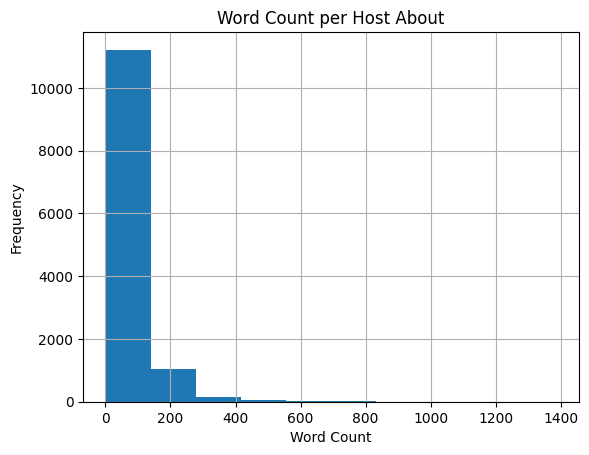

In [85]:
airbnb_df_train_COUNTW['word_count_host'].hist()
plt.title("Word Count per Host About")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

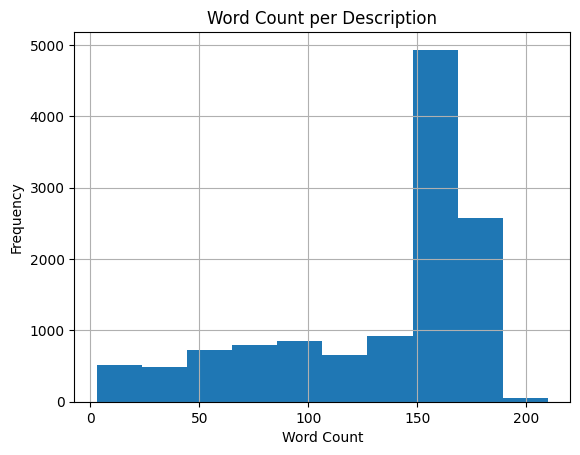

In [86]:
airbnb_df_train_COUNTW['word_count_description'].hist()
plt.title("Word Count per Description")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

In [87]:
reviews_df_train_COUNTW = pd.DataFrame()
reviews_df_train_COUNTW['comments'] = reviews_df_train['comments']
reviews_df_train_COUNTW['word_count_comm']  = reviews_df_train_COUNTW['comments'].apply(lambda x: len(str(x).split(" ")))
reviews_df_train_COUNTW[['comments','word_count_comm']].sort_values(by = ['word_count_comm'],ascending=False).head()

comments  word_count_comm
478814  This feedback and review is based on our stay ...             1064
120285  This is the first bad review I have ever writt...             1019
408765  The apartment is nice and the view is amazing,...             1007
145075  Longe de atender minhas espectativas, vou come...             1005
174862  We strongly recommend Villa Roma Townhouse/Apt...             1003

Text(0, 0.5, 'Frequency')

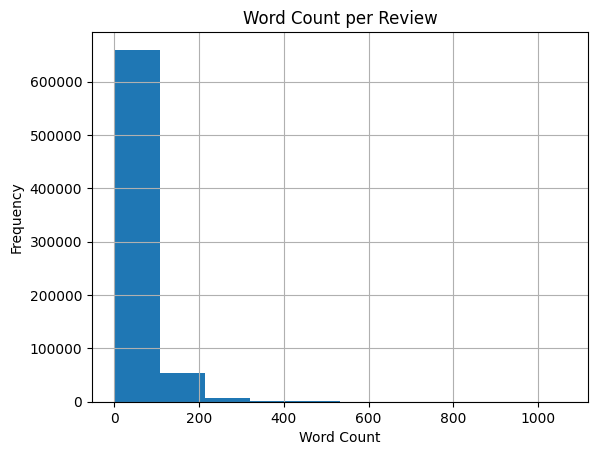

In [88]:
reviews_df_train_COUNTW['word_count_comm'].hist()
plt.title("Word Count per Review")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

### Most frequent words

In [89]:
all_words_desc = ' '.join(airbnb_df_train['description']).split()
freq_desc = pd.Series(all_words_desc).value_counts()
print("Most frequent words in airbnb descriptions: ")
freq_desc.sort_values(ascending=False)[0:10]

Most frequent words in airbnb descriptions: 


the      62717
and      54907
a        50700
/><br    34826
to       30520
of       30050
in       28007
with     27033
is       23957
de       13708
dtype: int64

In [90]:
all_words_about = ' '.join(airbnb_df_train['host_about']).split()
freq_about = pd.Series(all_words_about).value_counts()
print("Most frequent words in airbnb host about: ")
freq_about.sort_values(ascending=False)[0:10]

Most frequent words in airbnb host about: 


and    32569
to     26540
the    21488
a      21184
in     19515
I      12752
of     12752
you    12511
de      8739
We      8457
dtype: int64

In [91]:
all_words_reviews = ' '.join(reviews_df_train['comments']).split()
freq_reviews = pd.Series(all_words_reviews).value_counts()
print("Most frequent words in airbnb reviews: ")
freq_reviews.sort_values(ascending=False)[0:10]

Most frequent words in airbnb reviews: 


and     1098408
the     1028194
a        793019
to       653238
is       511900
in       497346
was      476359
of       347891
very     311495
The      285011
dtype: int64

<a class="anchor" id="topic03.03" /><br>
### 3.3 Preprocessing the data

### Removing Html

In [92]:
airbnb_html = cleanhtml(airbnb_df_train)
reviews_html = cleanhtml(reviews_df_train)

print(f"\033[1mBefore: \033[0m{airbnb_df_train['description'][10]}", "\n")
print(f"\033[1mAfter: \033[0m{airbnb_html['description'][9]}")

Before: Walk up original wooden stairs to the entrance of an apartment bathed in light. Here, wooden fixtures rest atop hardwood floors and are accentuated by bold blues and vibrant plant life. Play a game on the tennis court and dive into the pool.<br /><br /><b>License number</b><br />80419/AL 

After: Walk up original wooden stairs to the entrance of an apartment bathed in light. Here, wooden fixtures rest atop hardwood floors and are accentuated by bold blues and vibrant plant life. Play a game on the tennis court and dive into the pool.   License number  80419/AL


### Lowercasing

In [93]:
reviews_lowercase = lowercasing(reviews_html)
airbnb_lowercase = lowercasing(airbnb_html)

print(f"\033[1mBefore: \033[0m{reviews_html['comments'][70]}", "\n")
print(f"\033[1mAfter: \033[0m{reviews_lowercase['comments'][70]}")

Before: A vista é deslumbrante, a zona é muito agradável para férias em família. Bons restaurantes e as pessoas muito simpáticas. A pessoa que nos recebeu no check-in foi muito atenciosa e muito disponível. 

After: a vista é deslumbrante, a zona é muito agradável para férias em família. bons restaurantes e as pessoas muito simpáticas. a pessoa que nos recebeu no check-in foi muito atenciosa e muito disponível.


Searching for nan inputed values and removing them

In [94]:
print(reviews_lowercase[reviews_lowercase['comments'] == 'nan'])

        index comments
359648   6221      nan


In [95]:
reviews_lowercase.drop(359648, inplace=True)

In [96]:
print(airbnb_lowercase[airbnb_lowercase['description'] == 'nan'], "\n")
print(airbnb_lowercase[airbnb_lowercase['host_about'] == 'nan'])

Empty DataFrame
Columns: [description, host_about, unlisted]
Index: [] 

Empty DataFrame
Columns: [description, host_about, unlisted]
Index: []


### Expand contractions

In [97]:
reviews_contractions = expand_contractions(reviews_lowercase)
airbnb_contractions = expand_contractions(airbnb_lowercase)

print(f"\033[1mBefore: \033[0m{reviews_lowercase['comments'][211]}", "\n")
print(f"\033[1mAfter: \033[0m{reviews_contractions['comments'][211]}")

Before: stayed here with friends and we had the most amazing time! check-in was very easy. close to transportation, restaurants, groceries, coffee shops, etc. shani responds in a timely manner and was always ready to help us out! would recommend this place. highly. 

After: stayed here with friends and we had the most amazing time! check-in was very easy. close to transportation, restaurants, groceries, coffee shops, etc. shani responds in a timely manner and was always ready to help us out! would recommend this place. highly.


### Remove punctuation

In [98]:
reviews_punctuation = remove_punctuation(reviews_contractions)
airbnb_punctuation = remove_punctuation(airbnb_contractions)

print(f"\033[1mBefore: \033[0m{reviews_contractions['comments'][71]}", "\n")
print(f"\033[1mAfter: \033[0m{reviews_punctuation['comments'][71]}")

Before: the stay was completely worth it. the apartment is a clean and modern place with plenty of clean linens and sheets and towels. the view from the balcony is absolutely mind-blowing and there are parking spaces all over. the host was very forthcoming and super friendly. 

After: the stay was completely worth it the apartment is a clean and modern place with plenty of clean linens and sheets and towels the view from the balcony is absolutely mind blowing and there are parking spaces all over the host was very forthcoming and super friendly 


### Erase emojis in the airbnb description dataset

In [99]:
airbnb_demojized = remove_emoji(airbnb_punctuation, ['description','host_about'])

### Detect languages present  in our datasets

In [100]:
airbnb_language = detect_language(airbnb_demojized, columns=text_columns_airbnb)
airbnb_language.head()

description  \
0  this is a shared mixed room in our hostel with...   
1  o meu espao fica perto de parque eduardo vii s...   
2  trafaria house is a cozy and familiar villa wh...   
3  apartamento charmoso no chiado entre o largo d...   
4  joli appartement en bordure de mer 2 min a pie...   

                                          host_about  unlisted  \
0                 alojamento local registro 20835 al         0   
1  i am friendly host and i will try to always be...         1   
2  i am a social person liking to communicate rea...         1   
3  hello x000d i m portuguese and i love to meet ...         0   
4  nous sommes une famille avec deux enfants de 1...         0   

  description_lang host_about_lang  
0               en              es  
1               pt              en  
2               en              en  
3               pt              en  
4               fr              fr

In [104]:
reviews_language = detect_language(reviews_punctuation, columns=text_columns_reviews)
reviews_language.head()

index                                           comments comments_lang
0      1  this is a very cozy and comfortable house to s...            en
1      1                                               good            so
2      1  my first hostel experience and all i have to s...            en
3      1  das hostel war neu und deshalb funktionierte a...            de
4      1  it was fine for a dorm but i think for the peo...            en

### Replace emojis in the Reviews dataset

In [15]:
reviews_emoji = convert_emoji(reviews_language,['comments'])


### Remove patterns of digits

In [110]:
reviews_emoji['comments'] = reviews_emoji['comments'].astype('string')
airbnb_digits = remove_digits(airbnb_language, text_columns_airbnb)
reviews_digits = remove_digits(reviews_emoji.dropna(), ['comments'])
print(f"\033[1mBefore: \033[0m{reviews_emoji['comments'][2]}", "\n")
print(f"\033[1mAfter: \033[0m{reviews_digits['comments'][2]}")

Before: my first hostel experience and all i have to say is it will be pretty hard to beat this place x000d i booked a room for 6 people and i ended up getting my own room there is a locker for each person in the room as well so i knew my belongings were safe since i was the only one with a key card for my room there is a 5 euro deposit for the keycard so do not lose it x000d the bed was more comfortable than mine at home and if you close the curtains shades it tunes out any cars driving by x000d you cannot ask for a better location i could see the parque metro station from my window the hostel is on the first floor of a really pretty building the metro was so convenient it came every 4 5 minutes or you could go to the many local cafes right outside or just walk for about 15 20 minutes down the street to get to all the fancy clothing boutiques x000d free breakfast was great the kitchen looks even better than it does in the picture brand new x000d i arrived in lisbon around 8am and they

### Remove stopwords

In [230]:
airbnb_stop = remove_stopwords(airbnb_digits, text_columns_airbnb)
reviews_stop = remove_stopwords(reviews_digits, text_columns_reviews)

print(f"\033[1mBefore: \033[0m{reviews_digits['comments'][2]}", "\n")
print(f"\033[1mAfter: \033[0m{reviews_stop['comments'][2]}")

Before: my first hostel experience and all i have to say is it will be pretty hard to beat this place i booked a room for  people and i ended up getting my own room there is a locker for each person in the room as well so i knew my belongings were safe since i was the only one with a key card for my room there is a  euro deposit for the keycard so do not lose it the bed was more comfortable than mine at home and if you close the curtains shades it tunes out any cars driving by you cannot ask for a better location i could see the parque metro station from my window the hostel is on the first floor of a really pretty building the metro was so convenient it came every   minutes or you could go to the many local cafes right outside or just walk for about   minutes down the street to get to all the fancy clothing boutiques free breakfast was great the kitchen looks even better than it does in the picture brand new i arrived in lisbon around am and they let me store all my belongings there b

### Lemmatize

In [231]:
lemma_airbnb= lemmatize(airbnb_stop, text_columns_airbnb)
lemma_reviews= lemmatize(reviews_stop, text_columns_reviews)

print(f"\033[1mBefore: \033[0m{reviews_stop['comments'][4]}", "\n")
print(f"\033[1mAfter: \033[0m{lemma_reviews['comments'][4]}")

Before: fine dorm think people staying far less bathrooms toilets could stand line 

After: fine dorm think people stay far less bathroom toilet could stand line


<a class="anchor" id="topic04" /><br>

# Step 4: Data Visualization

[Back to Index](#index)

**Percentage of language in each dataset:**

In [105]:
description_languages= lang_percentage(10, airbnb_language, 'description_lang')

In [106]:
fig= px.pie(description_languages, values='count', names='languages', title="Listings languages")

fig.update_traces(textposition='inside', textinfo='percent+label')

In [107]:
reviews_languages= lang_percentage(10, reviews_language, 'comments_lang')

In [108]:
fig= px.pie(reviews_languages, values='count', names='languages', title="Reviews languages")

fig.update_traces(textposition='inside', textinfo='percent+label')

## Wordcloud

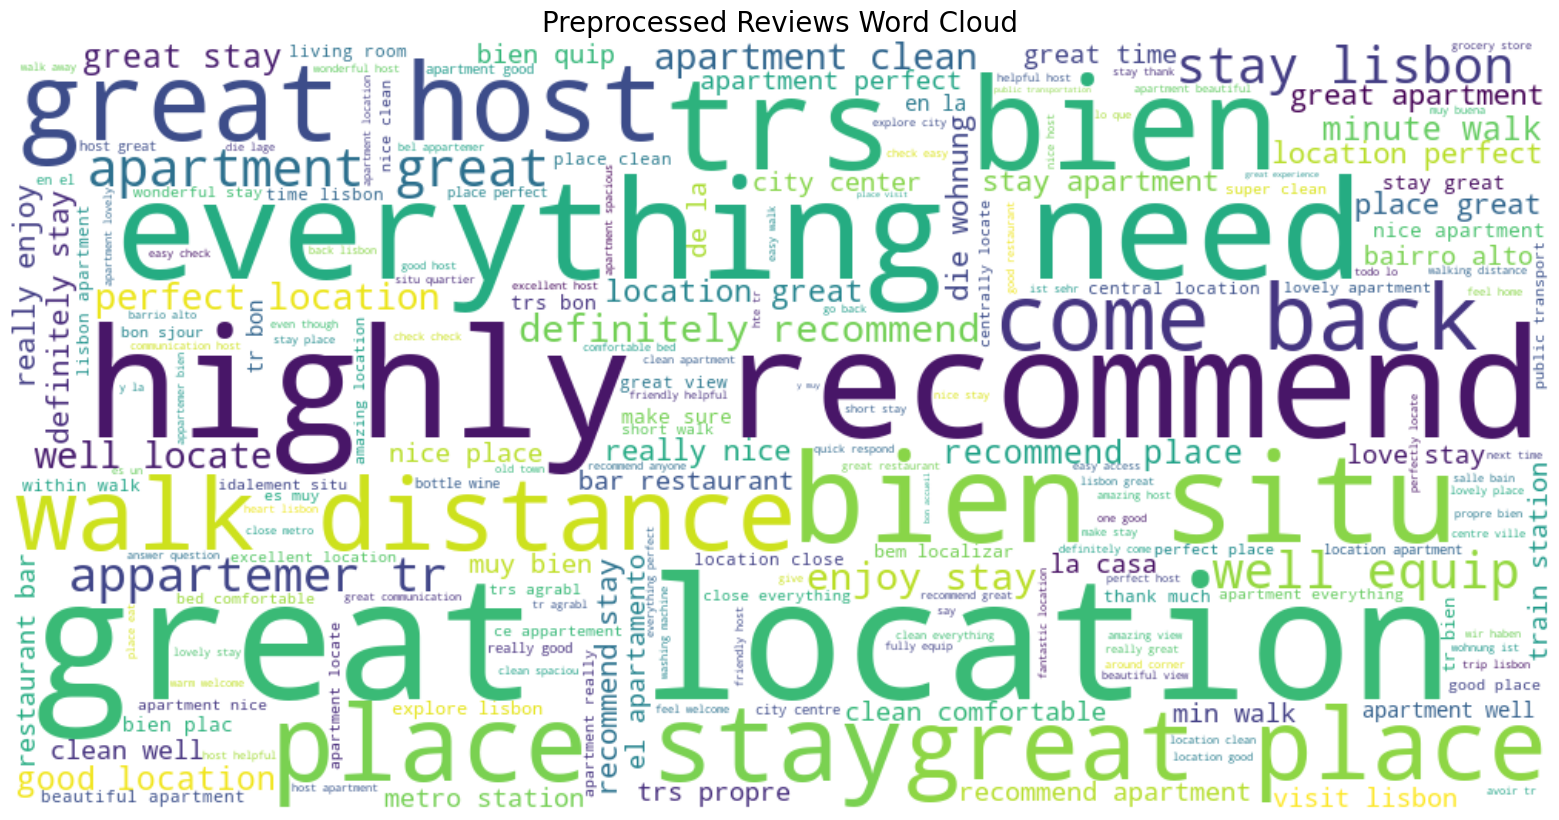

In [232]:
text = " ".join(i for i in lemma_reviews.comments)
wordcloud = WordCloud(background_color="white", width=1000, height=500).generate(text)
plt.figure( figsize=(30,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Preprocessed Reviews Word Cloud", fontsize=20) 
plt.axis("off")
plt.show()

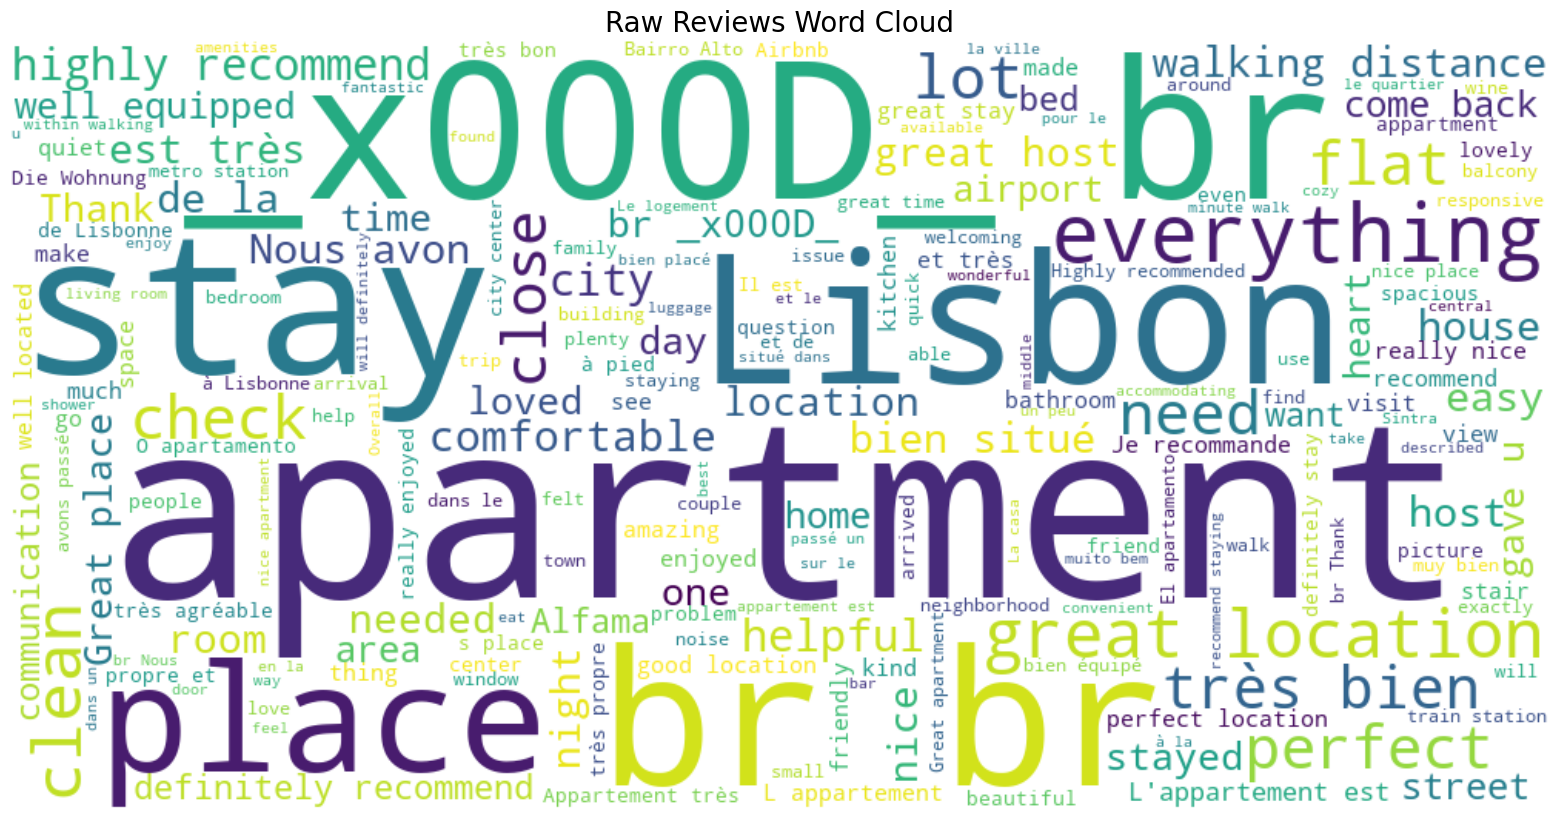

In [233]:
text = " ".join(i for i in reviews_df_train.comments)
wordcloud = WordCloud(background_color="white", width=1000, height=500).generate(text)
plt.figure( figsize=(30,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Raw Reviews Word Cloud", fontsize=20) 
plt.axis("off")
plt.show()

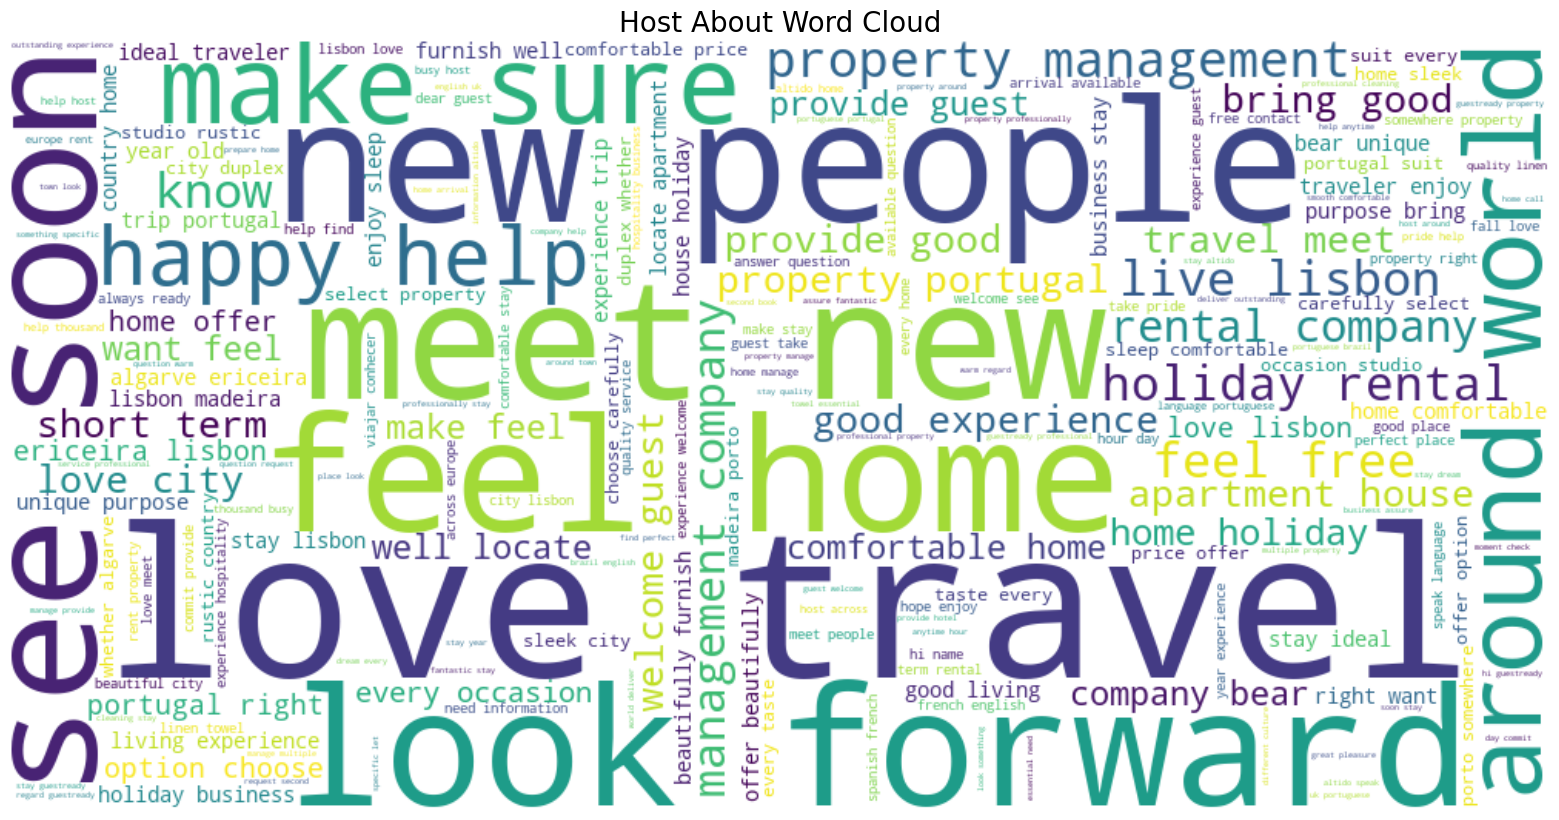

In [9]:
text = " ".join(i for i in lemma_airbnb['host_about'])
wordcloud = WordCloud(background_color="white", width=1000, height=500).generate(text)
plt.figure( figsize=(30,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Host About Word Cloud", fontsize=20) 
plt.axis("off")
plt.show()

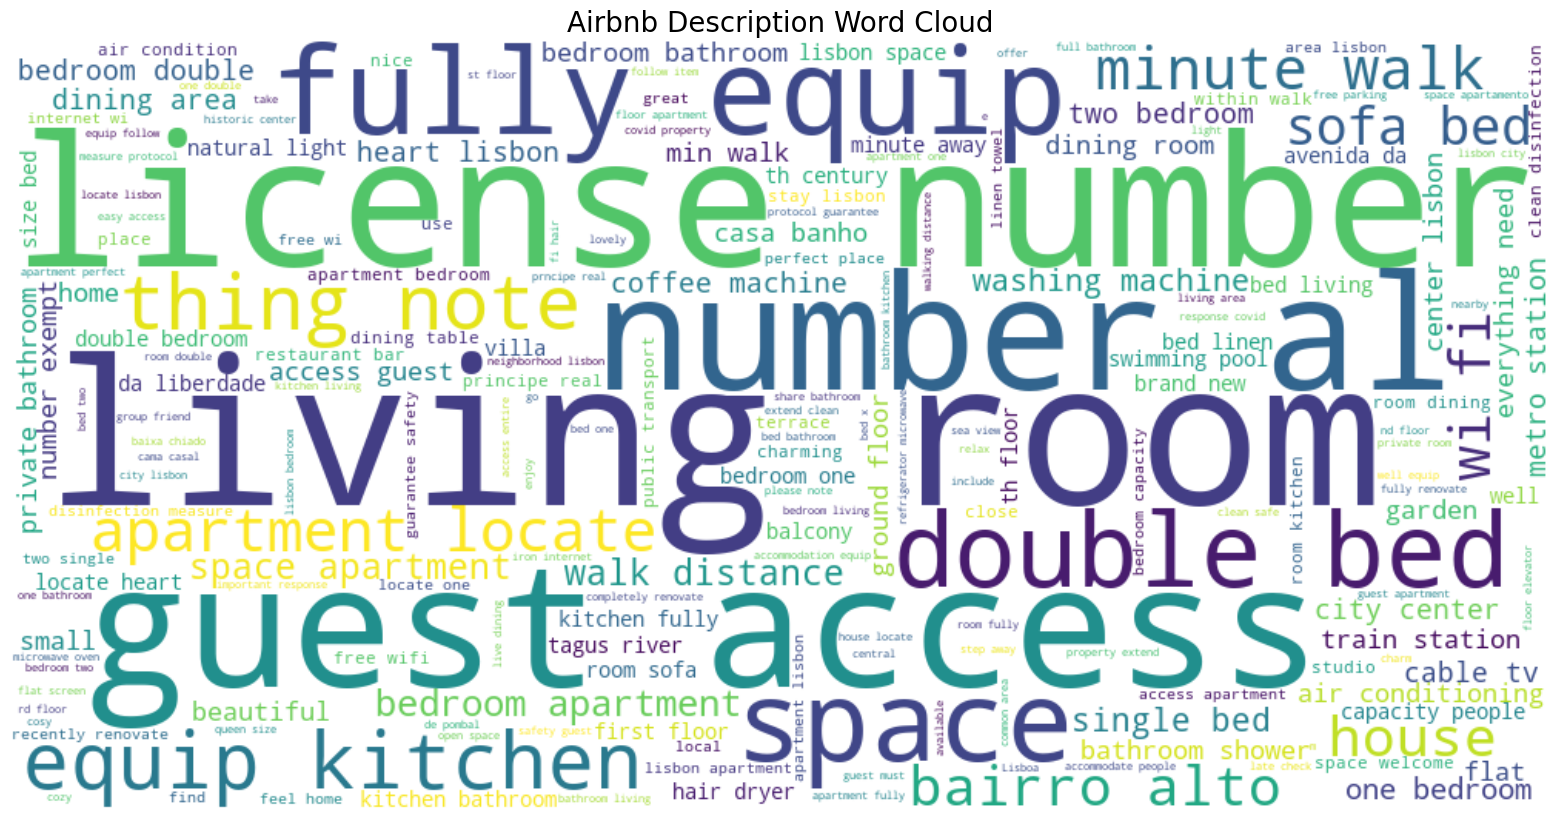

In [10]:
text = " ".join(i for i in lemma_airbnb.description)
wordcloud = WordCloud(background_color="white", width=1000, height=500).generate(text)
plt.figure( figsize=(30,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Airbnb Description Word Cloud", fontsize=20) 
plt.axis("off")
plt.show()

Number of listed and unlisted 

In [236]:
(lemma_airbnb['unlisted']).value_counts()

0    9033
1    3463
Name: unlisted, dtype: int64

<Axes: >

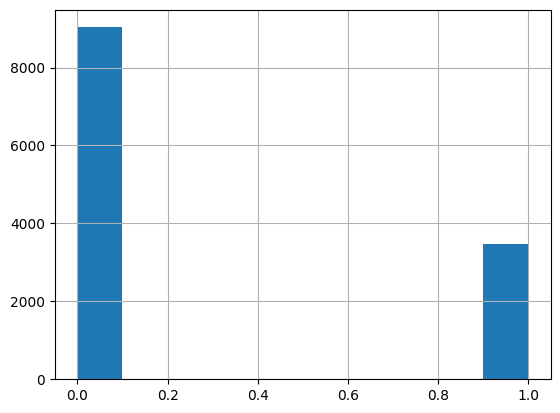

In [237]:
lemma_airbnb['unlisted'].hist()

Number of airbnbs with review (from 12496 there's 8467 with reviews)

In [238]:
lemma_reviews['index'].nunique()

8467

Number of reviwes for each airbnb 

In [239]:
lemma_reviews.groupby('index').count().sort_values('comments',ascending=False)

comments  comments_lang
index                         
8911       1173           1173
9374        895            895
265         887            887
6720        788            788
3396        762            762
...         ...            ...
5331          1              1
752           1              1
8203          1              1
9878          1              1
10320         1              1

[8467 rows x 2 columns]

array([[<Axes: title={'center': 'comments'}>,
        <Axes: title={'center': 'comments_lang'}>]], dtype=object)

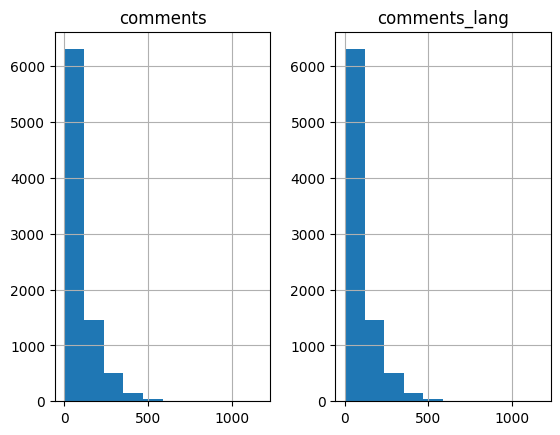

In [240]:
lemma_reviews.groupby('index').count().sort_values('comments',ascending=False).hist()

In [241]:
# Fetch wordcount for each abstract
lemma_airbnb_COUNTW = pd.DataFrame()
lemma_airbnb_COUNTW['description'] = lemma_airbnb['description']
lemma_airbnb_COUNTW['host_about'] = lemma_airbnb['host_about']
lemma_airbnb_COUNTW['word_count_desc']  = lemma_airbnb['description'].apply(lambda x: len(str(x).split(" ")))
lemma_airbnb_COUNTW['word_count_about']  = lemma_airbnb['host_about'].apply(lambda x: len(str(x).split(" ")))
lemma_airbnb_COUNTW[['description','word_count_desc','host_about','word_count_about']].head(10).sort_values(by = ['word_count_desc','word_count_about'],ascending=False)

description  word_count_desc  \
2  trafaria house cozy familiar villa facility ne...               97   
8  charming apartment one bedroom double bed doub...               88   
6  home rent travel perfect vacation without car ...               82   
5  important response covid property extend clean...               81   
4  joli appartemer bordure mer min avoir pied pla...               72   
0  share mixed room hostel share bathroom locate ...               70   
7  find tranquility meticulously curate lifestyle...               65   
9  walk original wooden stair entrance apartment ...               29   
3  apartamento charmoso chiar largo Carmo travess...               28   
1  espao ficar perto parque eduardo Vii saldanha ...               15   

                                          host_about  word_count_about  
2  social person like communicate reading travel ...                23  
8  isabel helder portuguese parent three wonderfu...                22  
6  globe trotter portuguese nationality german fa...                22  
5  hi home company develop activity tourism provi...                53  
4  famille deux enfant an habit pendant plusieurs...                18  
0                      alojamento local registro  al                 5  
7  travel lot love originally israel currently sp...                50  
9  service holiday apartment casa azenhas mar com...                14  
3  hello portuguese love meet people around word ...                16  
1  friendly host try always around need anything ...                12

In [242]:
lemma_airbnb_COUNTW.word_count_about.describe()

count    12496.000000
mean        42.797775
std         58.109032
min          1.000000
25%         14.000000
50%         29.000000
75%         56.000000
max       1412.000000
Name: word_count_about, dtype: float64

<Axes: >

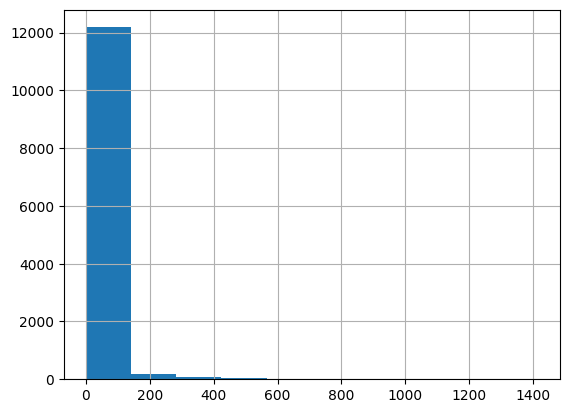

In [243]:
lemma_airbnb_COUNTW['word_count_about'].hist()

In [244]:
lemma_airbnb_COUNTW.word_count_desc.describe()

count    12496.000000
mean        76.513284
std         29.056881
min          2.000000
25%         58.000000
50%         86.000000
75%         94.000000
max        183.000000
Name: word_count_desc, dtype: float64

<Axes: >

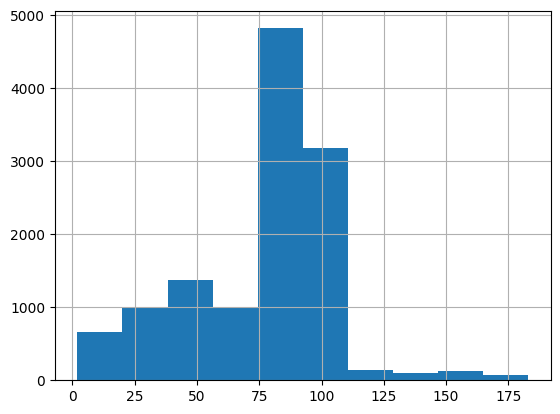

In [245]:
lemma_airbnb_COUNTW['word_count_desc'].hist()

In [246]:
lemma_reviews_COUNTW = pd.DataFrame()
lemma_reviews_COUNTW['comments'] = lemma_reviews['comments']
lemma_reviews_COUNTW['word_count_comm']  = lemma_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
lemma_reviews_COUNTW[['comments','word_count_comm']].sort_values(by = ['word_count_comm'],ascending=False).head(10)

comments  word_count_comm
625582  unfortunately we cannot recommend this accommo...             1013
209815  leider kann ich diese unterkunft nicht empfehl...              884
342356  lappartamento  decisamente un piccolo gioiello...              835
37626   mafalda war wirklich eine sehr nette gastgeber...              739
154471  i usually do not like to write reviews like th...              707
548728  esta foi minha primeira experincia airbnb part...              690
668655  claudia is amazing as is her apartment which i...              684
349389  die kommunikation mit dem gastgeber verlief pr...              673
535604  the hospitality of iris and her parents can ha...              669
40357   bonjour voici mon avis concernant cet appartem...              646

In [247]:
lemma_reviews_COUNTW.word_count_comm.describe()

count    719678.000000
mean         28.945013
std          28.437814
min           1.000000
25%          11.000000
50%          21.000000
75%          37.000000
max        1013.000000
Name: word_count_comm, dtype: float64

In [248]:
all_words_desc = ' '.join(lemma_airbnb['description']).split()
freq_desc = pd.Series(all_words_desc).value_counts()
freq_desc.sort_values(ascending=False)[0:10]

apartment    18713
lisbon       12457
space        12055
room         11519
bedroom       9244
bed           8465
guest         7863
locate        7481
kitchen       7335
bathroom      6396
dtype: int64

In [249]:
all_words_about = ' '.join(lemma_airbnb['host_about']).split()
freq_about = pd.Series(all_words_about).value_counts()
freq_about.sort_values(ascending=False)[0:10]

lisbon        8211
love          5482
home          4744
stay          4190
travel        3960
experience    3943
apartment     3811
guest         3809
portugal      3555
city          3517
dtype: int64

In [250]:
## frequency of words

all_words_reviews = ' '.join(lemma_reviews['comments']).split()
freq_reviews = pd.Series(all_words_reviews).value_counts()
freq_reviews.sort_values(ascending=False)[0:10]

apartment    315056
great        278560
stay         256648
place        220896
location     207463
lisbon       155261
host         147414
we           140761
clean        134929
nice         134664
dtype: int64

<Axes: >

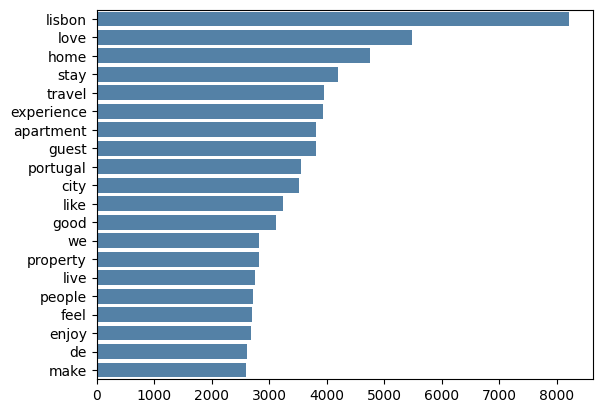

In [251]:
new= lemma_airbnb['host_about'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x, color='steelblue')


In [252]:
lemma_reviews

index                                           comments comments_lang
0           1  cozy comfortable house stay never worry safety...            en
1           1                                               good            so
2           1  first hostel experience say pretty hard beat p...            en
3           1  das hostel war neu und deshalb funktionierte a...            de
4           1  fine dorm think people stay far less bathroom ...            en
...       ...                                                ...           ...
719673  12494  good time apartment great location close hustl...            en
719674  12494  great apartment central location host responsi...            en
719675  12494  airbnb super host trust liliana super sup supe...            en
719676  12494  lovely stay apartment sofia helpful offer chec...            en
719677  12494  clean good position easy checkin place everyth...            en

[719678 rows x 3 columns]

<a class="anchor" id="topic05" /><br>
# Step 5: Import and Exploration of Sentiment Analysis
[Back to Index](#index)

In [255]:
reviews_sentiment = sentiment_reviews(lemma_reviews,columns=text_columns_reviews)

Sentiment Analysis of comments: 100%|██████████| 719678/719678 [30:53<00:00, 388.24it/s]  


In [13]:
# Create a value count of the 'sentiment' column for the first pie chart
sentiment_counts_1 = reviews_sentiment['sentiment'].value_counts()

# Map the labels for the first pie chart
labels_map = {1: 'POSITIVE', 0: 'NEUTRAL', -1: 'NEGATIVE'}
sentiment_counts_1.index = sentiment_counts_1.index.map(labels_map)

# Create a value count of the 'sentiment' column for the second pie chart
sentiment_counts_2 = reviews_sentiment.loc[reviews_sentiment['comments_lang'].isin(['pt', 'en', 'fr']), 'sentiment'].value_counts()

# Map the labels for the second pie chart
sentiment_counts_2.index = sentiment_counts_2.index.map(labels_map)

# Define the custom colors for the pie charts
colors = ['#94b9a7', '#3a6c7f',  '#9d3819']

# Create subplots with two columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('All Languages', 'English, Portuguese and French'), specs=[[{'type': 'pie'}, {'type': 'pie'}]])

# Add the first pie chart with custom colors
fig.add_trace(go.Pie(labels=sentiment_counts_1.index, values=sentiment_counts_1.values, marker=dict(colors=colors)), row=1, col=1)

# Add the second pie chart with custom colors
fig.add_trace(go.Pie(labels=sentiment_counts_2.index, values=sentiment_counts_2.values, marker=dict(colors=colors)), row=1, col=2)

# Update layout with titles for each subplot
fig.update_layout(
    title_text="Sentiment Analysis",
    annotations=[
        dict(text="All Languages", x=0.225, y=1.05, xref='paper', yref='paper', showarrow=False, font=dict(size=14)),
        dict(text="English, Portuguese and French", x=0.775, y=1.05, xref='paper', yref='paper', showarrow=False, font=dict(size=14))
    ]
)

# Show the pie charts
fig.show()


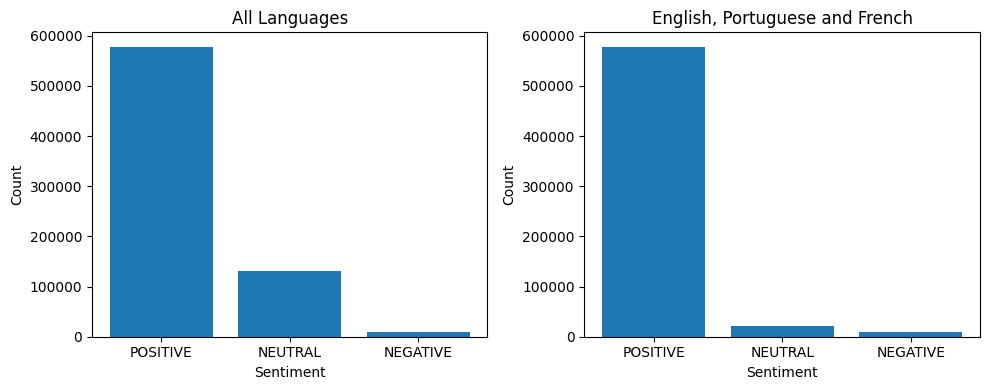

In [14]:
# Create subplots with two columns
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Count the occurrences of each category for all languages
sentiment_counts_all = reviews_sentiment['sentiment'].value_counts()
sentiment_counts_all.index = sentiment_counts_all.index.map(labels_map)

# Create the bar plot for all languages
axs[0].bar(sentiment_counts_all.index, sentiment_counts_all.values)
axs[0].set_title('All Languages')
axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Count')

# Count the occurrences of each category for English and Portuguese
sentiment_counts_en_pt = reviews_sentiment.loc[reviews_sentiment['comments_lang'].isin(['pt', 'en','fr']), 'sentiment'].value_counts()
sentiment_counts_en_pt.index = sentiment_counts_en_pt.index.map(labels_map)

# Create the bar plot for English and Portuguese
axs[1].bar(sentiment_counts_en_pt.index, sentiment_counts_en_pt.values)
axs[1].set_title('English, Portuguese and French')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Count')

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()
